In [1]:
import os, sys
import datetime
from datetime import datetime, date, timedelta
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas_profiling import ProfileReport
import mglearn
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg'
from mpl_toolkits.mplot3d import Axes3D, axes3d
from scipy import sparse
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import pingouin as pg
import spacy, nltk
from konlpy.tag import Okt

c:\Users\admin\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from sklearn.datasets import load_files

In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline

In [4]:
reviews_train = load_files('aclImdb/train/')
reviews_test = load_files('aclImdb/test/')

In [5]:
text_train, y_train = reviews_train['data'], reviews_train['target']
text_test, y_test = reviews_test['data'], reviews_test['target']

In [7]:
text_train = [doc.replace(b'<br />', b'') for doc in text_train]
text_test = [doc.replace(b'<br />', b'') for doc in text_test]

In [8]:
np.bincount(y_train), np.bincount(y_test)

(array([12500, 12500], dtype=int64), array([12500, 12500], dtype=int64))

In [10]:
bards_words = ['The fool doth think he is wise.', 'but the wise man knows himself to be a fool.']

In [11]:
vect = CountVectorizer().fit(bards_words)
vect.vocabulary_

{'the': 9,
 'fool': 3,
 'doth': 2,
 'think': 10,
 'he': 4,
 'is': 6,
 'wise': 12,
 'but': 1,
 'man': 8,
 'knows': 7,
 'himself': 5,
 'to': 11,
 'be': 0}

In [15]:
bow = vect.transform(bards_words)
bow.toarray(), vect.get_feature_names_out()

(array([[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1],
        [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]], dtype=int64),
 array(['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man',
        'the', 'think', 'to', 'wise'], dtype=object))

In [16]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [20]:
vect.get_feature_names_out().shape, X_train.shape, X_test.shape

((75911,), (25000, 75911), (25000, 75911))

In [27]:
[text_train[i] for i in np.argwhere(X_train[:, 9] == 1)[:, 0]][0]

b'"Dutch Schultz", AKA Arthur Fleggenheimer, was a real person and his rather nasty life is fairly well documented. This movie which purports to depict his life should have used a fictional character, because the overdramatized events are too strong a departure from the facts and the chronology. Not only that, it ignores some interesting details which other versions have included such as the public relations fiasco in upstate N.Y. and his religious conversion. It is true that he was executed by Luciano, Lansky, et. al. but that\'s as far as it goes. The exploding plate scene which represents Luciano carrying out the execution of Bo Weinberg in his own home, assisted by his own mother is rediculous. Also, there is the scene in which Dutch approaches his own mother to pay protection to Legs Diamond. It just doesn\'t work. The character of Mrs. Fleggenheimer doesn\'t work either. This movie does not need a doting Jewish mother for comic relief. The lame representation of Legs Diamond was 

In [31]:
np.mean(cross_val_score(LogisticRegression(C=0.1, max_iter=1000), X_train, y_train, n_jobs=-1))

0.8884000000000001

In [32]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [34]:
vect.get_feature_names_out().shape, X_train.shape, X_test.shape

((27264,), (25000, 27264), (25000, 27264))

In [35]:
np.mean(cross_val_score(LogisticRegression(C=0.1, max_iter=1000), X_train, y_train, n_jobs=-1))

0.8880399999999999

In [39]:
list(ENGLISH_STOP_WORDS)[::30]

['thick',
 'have',
 'hundred',
 'if',
 'formerly',
 'between',
 'beyond',
 'take',
 'find',
 'though',
 'they']

In [40]:
vect = CountVectorizer(min_df=5, stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [41]:
vect.get_feature_names_out().shape, X_train.shape, X_test.shape

((26959,), (25000, 26959), (25000, 26959))

In [42]:
np.mean(cross_val_score(LogisticRegression(C=0.1, max_iter=1000), X_train, y_train, n_jobs=-1))

0.88296

In [45]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))

In [47]:
param_grid = {'logisticregression__C':np.logspace(-2, 0, 3)}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1).fit(text_train, y_train)

In [48]:
grid.best_params_, grid.best_score_, grid.score(text_test, y_test)

({'logisticregression__C': 1.0}, 0.88788, 0.88328)

In [49]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train = vect.transform(text_train)
X_test = vect.transform(text_test)

In [62]:
# 특성별로 가장 큰 값 찾기
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = vect.get_feature_names_out()
# tfidf가 낮은 특성은 전체 문서에 걸쳐 사용 ↔ 높은 특성은 일부 문서에만 나타나는 형태
feature_names[sorted_by_tfidf[:20]], feature_names[sorted_by_tfidf[-20:]]

(array(['suplexes', 'gauche', 'hypocrites', 'oncoming', 'galadriel',
        'songwriting', 'emerald', 'mclaughlin', 'sylvain', 'oversee',
        'cataclysmic', 'pressuring', 'uphold', 'thieving', 'inconsiderate',
        'ware', 'denim', 'reverting', 'booed', 'spacious'], dtype=object),
 array(['gadget', 'zatoichi', 'demons', 'lennon', 'bye', 'sucks', 'dev',
        'weller', 'sasquatch', 'botched', 'xica', 'darkman', 'woo',
        'casper', 'doodlebops', 'smallville', 'wei', 'scanners', 'steve',
        'pokemon'], dtype=object))

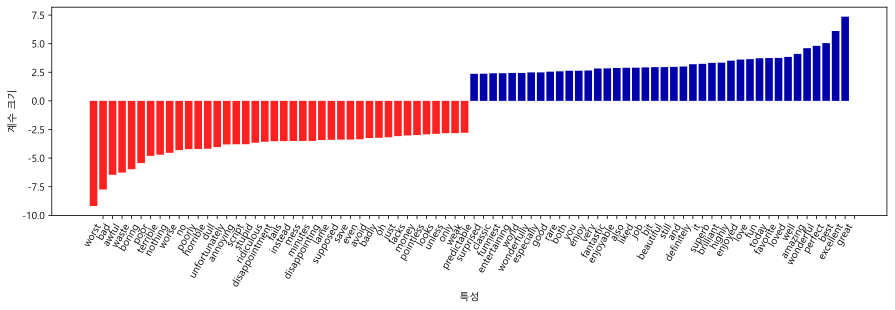

In [63]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_[0], feature_names, n_top_features=40)

In [64]:
# BOW 표현 방식은 단어의 순서가 완전히 무시된다는 단점
first_sentence = '''it's bad, not good at all'''
second_sentence = '''it's good, not bad at all'''

In [65]:
bards_words = ['The fool doth think he is wise.', 'but the wise man knows himself to be a fool.']

In [67]:
vect = CountVectorizer(ngram_range=(1, 2)).fit(bards_words)
vect.vocabulary_, vect.get_feature_names_out()

({'the': 18,
  'fool': 6,
  'doth': 4,
  'think': 21,
  'he': 8,
  'is': 12,
  'wise': 25,
  'the fool': 19,
  'fool doth': 7,
  'doth think': 5,
  'think he': 22,
  'he is': 9,
  'is wise': 13,
  'but': 2,
  'man': 16,
  'knows': 14,
  'himself': 10,
  'to': 23,
  'be': 0,
  'but the': 3,
  'the wise': 20,
  'wise man': 26,
  'man knows': 17,
  'knows himself': 15,
  'himself to': 11,
  'to be': 24,
  'be fool': 1},
 array(['be', 'be fool', 'but', 'but the', 'doth', 'doth think', 'fool',
        'fool doth', 'he', 'he is', 'himself', 'himself to', 'is',
        'is wise', 'knows', 'knows himself', 'man', 'man knows', 'the',
        'the fool', 'the wise', 'think', 'think he', 'to', 'to be', 'wise',
        'wise man'], dtype=object))

In [68]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))

In [71]:
param_grid = {'tfidfvectorizer__ngram_range':[(1, 1), (1, 2), (1, 3)], 'logisticregression__C':np.logspace(-1, 1, 3)}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1).fit(text_train, y_train)

In [72]:
grid.best_params_, grid.best_score_, grid.score(text_test, y_test)

({'logisticregression__C': 10.0, 'tfidfvectorizer__ngram_range': (1, 3)},
 0.9059999999999999,
 0.90376)

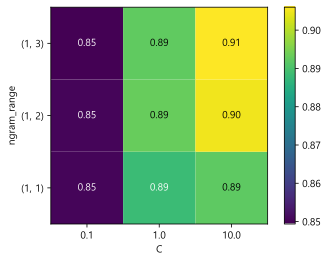

In [73]:
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
heatmap = mglearn.tools.heatmap(scores, xlabel='C', ylabel='ngram_range',
xticklabels=param_grid['logisticregression__C'], yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

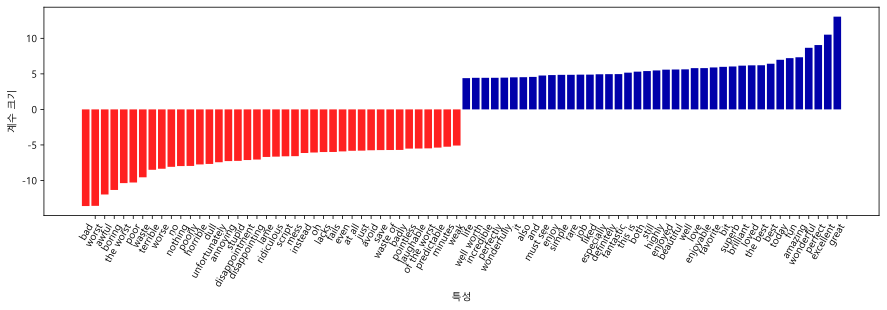

In [76]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = vect.get_feature_names_out()
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_[0], feature_names, n_top_features=40)

In [77]:
en_nlp = spacy.load('en_core_web_sm')
stemmer = nltk.stem.PorterStemmer()

In [78]:
def compare_normalization(doc):
    doc_spacy = en_nlp(doc)
    print('Lemma')
    print([token.lemma_ for token in doc_spacy])
    print('Stem')
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [79]:
doc = '''Our meeting today was worse than yesterday. I'm scared of meeting the clients tomorrow'''
compare_normalization(doc)

Lemma
['our', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', '.', 'I', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow']
Stem
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', '.', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow']


In [80]:
en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [83]:
def custom_tokenizer(doc):
    return [token.lemma_ for token in en_nlp(doc)]

In [86]:
pipe = make_pipeline(CountVectorizer(tokenizer=custom_tokenizer, min_df=5), LogisticRegression(max_iter=5000))

In [89]:
param_grid = {'countvectorizer__ngram_range':[(1, 1), (1, 2)], 'logisticregression__C':np.logspace(-2, 2, 5)}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1).fit(text_train, y_train)

In [ ]:
grid.best_params_, grid.best_score_

In [ ]:
lemma_vect = grid.best_estimator_.named_steps['countvectorizer'].fit(text_train)
X_train_lemma = lemma_vect.transform(text_train)
X_test_lemma = lemma_vect.transform(text_test)

In [ ]:
X_train_lemma.shape, lemma_vect.get_feature_names_out().shape

In [ ]:
vect = CountVectorizer(tokenizer=custom_tokenizer, max_features=10000, max_df=0.15).fit(text_train)
X = vect.transform(text_train)

In [ ]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch', max_iter=25, random_state=0, n_jobs=-1).fit(X)
document_topics = lda.transform(X)

In [ ]:
# components_ 속성의 shape는 (n_topics, n_words)
lda.components_.shape

In [ ]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = vect.get_feature_names_out()
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

In [ ]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method='batch', max_iter=25, random_state=0, n_jobs=-1).fit(X)
document_topics100 = lda100.transform(X)

In [ ]:
topics = np.array([7, 16, 24, 25, 28, 36, 37, 41, 45, 51])
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = vect.get_feature_names_out()
mglearn.tools.print_topics(topics=topics, feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

In [ ]:
music = np.argsort(document_topics100[:, 45])[::-1]
for i in music[:5]:
    print(b'.'.join(text_train[i].split(b'.')[:2]) + b'.\n\n')